## Setup

In [ ]:
!python3 -m pip install --upgrade pip

# dependencies
!pip3 install requests
!pip3 install beautifulsoup4
!pip3 install pandas
!pip3 install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Step 1: Data Extraction

In [ ]:
import requests
from bs4 import BeautifulSoup

api_endpoint = 'https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/'

page = requests.get(api_endpoint)
soup = BeautifulSoup(page.content, 'html.parser')

### Table attribute names

In [ ]:
# get column names
thead = soup.find('thead')  # table header
col_name_elems = thead.find_all('th')
col_names = [col_name_elem.text for col_name_elem in col_name_elems]

col_names

['Rank', 'Name', 'Market Cap', 'Price', 'Today', 'Price (30 days)', 'Country']

In [ ]:
# columns = ['Rank', 'Name', 'Market Cap', 'Price', 'Today', 'Price (30 days)', 'Country']

''' sample row
 <td class="rank-td td-right" data-sort="1">1</td>,
 <td class="name-td"><div class="logo-container"><img alt="Apple logo" class="company-logo" data-img-dark-path="/img/company-logos/64/AAPL.D.png" data-img-path="/img/company-logos/64/AAPL.png" loading="lazy" src="/img/company-logos/64/AAPL.png"/></div><div class="name-div"><a href="/apple/marketcap/"><div class="company-name">Apple</div><div class="company-code"><span class="rank d-none"></span>AAPL</div></a></div></td>,
 <td class="td-right" data-sort="2339821584384">$2.339 T</td>,
 <td class="td-right" data-sort="14788.5">$147.88</td>,
 <td class="rh-sm" data-sort="80"><span class="percentage-green"><svg class="a" viewbox="0 0 12 12"><path d="M10 8H2l4-4 4 4z"></path></svg>0.80%</span></td>,
 <td class="p-0 sparkline-td green"><svg><path d="M0,41 5,41 10,39 15,40 20,40 25,35 30,29 35,27 40,28 45,24 50,20 55,26 60,23 65,21 70,11 75,5 80,10 85,4 90,9 95,11 100,11 105,6 110,7 115,3 120,6 125,8 130,8 135,16 140,15 145,14 150,19 155,16"></path></svg></td>,
 <td>🇺🇸 <span class="responsive-hidden">USA</span></td>
'''

def extract_rows_from_page(page_num):
  query_param = '?page=' + str(page_num)
  page_page = requests.get(api_endpoint + query_param)
  page_soup = BeautifulSoup(page_page.content, 'html.parser')

  td_elems = page_soup.find_all('td')
  page_data = []

  i = 0
  while i < len(td_elems):
    assert(i + len(col_names) - 1 < len(td_elems))
    assert('rank-td' in td_elems[i]['class'])         # rank
    assert('name-td' in td_elems[i + 1]['class'])     # name
    assert('td-right' in td_elems[i + 2]['class'])    # market_cap
    assert('td-right' in td_elems[i + 3]['class'])    # price
    assert(td_elems[i + 6].find('span'))              # country

    rank = int(td_elems[i].text)
    name = td_elems[i + 1].find('div', class_='company-name').text
    market_cap = td_elems[i + 2].text
    price = td_elems[i + 3].text
    country = td_elems[i + 6].find('span').text

    page_data.append([rank, name, market_cap, price, country])
    i += len(col_names)
  
  return page_data


In [ ]:
num_pages = 2
table = []
for i in range(num_pages):
  table.extend(extract_rows_from_page(i + 1))

## Step 2: Data Transformation and Load

In [ ]:
import pandas as pd

print("Columns: " + str(col_names))
col_names = [col_names[0], col_names[1], col_names[2], col_names[3], col_names[6]]
print("Columns in use: " + str(col_names))

df = pd.DataFrame(table, columns=col_names)
df.head(10)

Columns: ['Rank', 'Name', 'Market Cap', 'Price', 'Today', 'Price (30 days)', 'Country']
Columns in use: ['Rank', 'Name', 'Market Cap', 'Price', 'Country']


,Rank,Name,Market Cap,Price,Country
0,1,Apple,$2.340 T,$147.92,USA
1,2,Microsoft,$1.862 T,$250.16,USA
2,3,Alphabet (Google),$1.152 T,$90.10,USA
3,4,Amazon,$960.78 B,$93.76,USA
4,5,Tesla,$656.96 B,$207.63,USA
5,6,NVIDIA,$585.64 B,$235.01,USA
6,7,TSMC,$452.73 B,$87.30,Taiwan
7,8,Meta Platforms (Facebook),$439.55 B,$169.54,USA
8,9,Tencent,$435.45 B,$44.61,China
9,10,Samsung,$312.87 B,$46.69,S. Korea


### Data Cleaning

#### Remove trailing newline in column Company Name

In [ ]:
df.dtypes

def remove_trailing_newline(row_name):
  if row_name[-1] != '/n':
    return row_name
  return row_name[:-1]

df = df.replace(r'\n', '', regex=True)

#### Transform column Market Cap

In [ ]:
df['Market Cap'] = df['Market Cap'].str.extract('\$(\d+\.\d+)\s[BT]').astype(float)
df.loc[0:2, 'Market Cap'] *= 1000
df.rename(columns={'Market Cap': 'Market Cap($ B)'}, inplace=True)

#### Transform column Stock Price

In [ ]:
df['Price'] = df['Price'].str.extract('\$(\d+\.\d+)').astype(float)
df.rename(columns={'Price': 'Price($)'}, inplace=True)

I scaped data from https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/ and in step 2, further processed data to make it cleaner for analysis.

- To export clean data into a CSV file as per the instruction, run ```df.to_csv("clean_data.csv")```

## Step 3: Analysis - Summary & Visualizations

<AxesSubplot:>

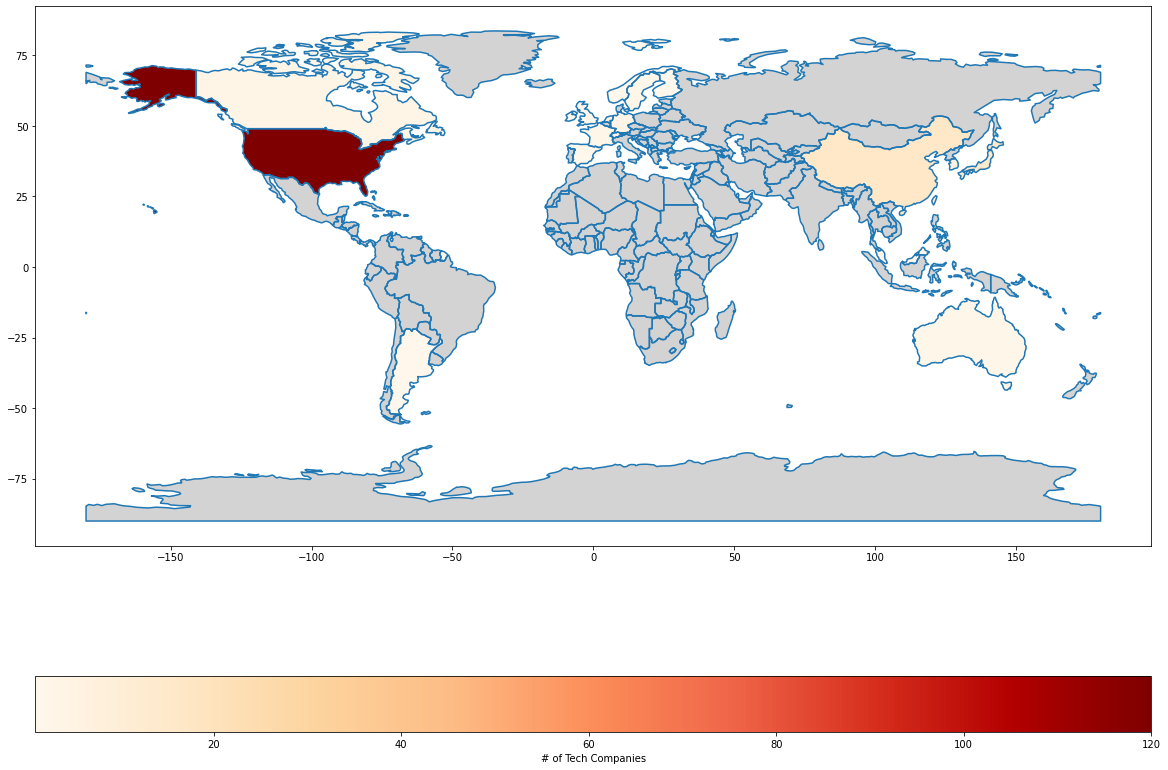

In [ ]:
import geopandas as gpd

df_count = df.groupby(by='Country').size().reset_index(name='# of Tech Companies')
df_count.sort_values(by='# of Tech Companies', ascending=False, inplace=True)

df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world = df_world.replace('United States of America', 'USA')
df_world = df_world.replace('South Korea', 'S. Korea')
df_world = df_world.replace('Malaysia', 'Singapore')
df_world = df_world.replace('United Kingdom', 'UK')

df_world_teams = df_world.merge(df_count, how='left', left_on=['name'], right_on=['Country'])

ax = df_world['geometry'].boundary.plot(figsize=(20,16))
df_world_teams.plot(column='# of Tech Companies', 
                    ax=ax, 
                    cmap='OrRd', 
                    legend=True, 
                    legend_kwds={
                         'label': '# of Tech Companies', 
                         'orientation':'horizontal'},
                    missing_kwds={'color': 'lightgrey'})

Summary: The graphs surprised me because the distribution of tech companies is way more concentrated than I expected.

## References

1. [Global Ranking](https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/)
2. [GeoPandas](https://geopandas.org/en/stable/)
3. [BeautifulSoup Tutorial](https://realpython.com/beautiful-soup-web-scraper-python/)